In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, concatenate
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, Embedding, LSTM
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, SGD, Adagrad
from tensorflow.keras import utils
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import gc
import datetime
from IPython.display import clear_output

sns.set()
pd.set_option('display.max_column', 50)

In [4]:
path = r""

In [5]:
df = pd.read_csv(path, sep=";").iloc[::2,::].reset_index(drop=True)
df

,Комнат,Метро / ЖД станции,От станции,Дом,Балкон,Санузел,Площадь,"Цена, руб.",ГРМ,Бонус агенту,Дата,Кол-во дней в экспозиции,Источник,Примечание
0,1,Шелепиха м.,12п,35/37 М,NaN,2,64.1/23/20,19500000.0,NaN,NaN,25.07.2019,1.0,Привлекательные,Собственность оформлена! Ключи на руках! Опера...
1,1,Пятницкое шоссе м.,30т,11/14 П,Л,Р,38.4/17/9,4800000.0,NaN,NaN,25.07.2019,2.0,Привлекательные,Зеленоград к.1820 однокомнатная квартира общ.3...
2,1,Планерная м.,5т,11/22 П,Б,С,38.2/19.9/9.9,7990000.0,NaN,NaN,25.07.2019,4.0,Привлекательные,"Уютная, светлая квартира, застекленный балкон ..."
3,1,Шаболовская м.,12п,8/12 ?,Б,Р,38/15/7,11200000.0,NaN,NaN,25.07.2019,7.0,Привлекательные,"Предлагаю 1- комн квартиру, в шаговой доступно..."
4,1,Бабушкинская м.,15п,4/14 П,NaN,С,34/17/8,6250000.0,NaN,NaN,25.07.2019,11.0,Привлекательные,Продается хорошая 1 комнатная квартира. 1 взро...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126263,Ст,Некрасовка м.,4п,2/17 П,NaN,NaN,19.8/?/?,2850000.0,NaN,NaN,12.07.2019,14.0,AVITO.ru,Уникальнейшее предложение! 7 минуты до метро! ...
126264,Ст,Авиамоторная м.,6п,2/8 К,NaN,С,20.4/18/?,3839990.0,NaN,NaN,23.07.2019,14.0,Яндекс,ВЫГОДНОЕ ПРЕДЛОЖЕНИЕ в пешей доступности от ме...
126265,Ст,Коломенская м.,15п,1/9 П,NaN,NaN,15.4/13.2/?,2900000.0,NaN,NaN,12.07.2019,14.0,AVITO.ru,СТУДИЯ В МОСКВЕ ПО ДОСТУПНОЙ ЦЕНЕ ! __________...
126266,Ст,Алтуфьево м.,5т,4/9 М,NaN,NaN,26/10.9/7,5200000.0,NaN,NaN,22.07.2019,14.0,AVITO.ru,Продается студия с отделкой в новом монолитном...


In [6]:
# оставим только 1-комнатные
df = df[df["Комнат"].apply(lambda x: True if x == "1" else False)]
dataset = pd.DataFrame()

In [7]:
def parseStationDistance(value):
    if value is np.nan:
        result = 0
    elif "п" in value:
        result = int(value[:-1])
    elif "т" in value:
        result = int(value[:-1]) * 5
    return result

tmp = df["От станции"].apply(parseStationDistance)
distanceScaler = StandardScaler()
distanceScaler.fit(tmp.values[...,None])
tmp = distanceScaler.transform(tmp.values[...,None])
dataset = pd.concat([dataset, pd.DataFrame(tmp.tolist(), columns=["dist"])], axis=1)

In [8]:
def parseBuilding(value):

    building = 0
    if "М" in value:
        building = 1
    elif "Б" in value:
        building = 2
    elif "К" in value:
        building = 3
    elif "П" in value:
        building = 4
    
    floor = value.split(" ")[0].split("/")[0]
    floor = int(floor) if floor.isdigit() else 0

    floors = value.split(" ")[0].split("/")[1]
    floors = int(floors) if floors.isdigit() else 0
    
    return building, floor, floors

        
tmp = df["Дом"].apply(parseBuilding)
tmp = pd.DataFrame(tmp.tolist())
dataset = pd.concat([dataset, 
                     pd.DataFrame(utils.to_categorical(tmp[0]).tolist(), columns=[f"b_{i}" for i in range(5)])
                    ], 
                    axis=1)
floorScaler = StandardScaler()
floorScaler.fit(tmp[[1,2]].values.reshape(-1,1))
floorScaler.transform(tmp[1].values[...,None])
dataset = pd.concat([dataset, pd.DataFrame(floorScaler.transform(tmp[1].values[...,None]).tolist(), columns=["floor"])], axis=1)
dataset = pd.concat([dataset, pd.DataFrame(floorScaler.transform(tmp[2].values[...,None]).tolist(), columns=["maxFloor"])], axis=1)

In [9]:
def parseBuilding(value):

    building = 0
    if "М" in value:
        building = 1
    elif "Б" in value:
        building = 2
    elif "К" in value:
        building = 3
    elif "П" in value:
        building = 4
    building = utils.to_categorical(building, 5)
    
    floor = value.split(" ")[0].split("/")[0]
    floor = int(floor) if floor.isdigit() else 1
    floor = min(max(int(np.log2(floor)) - 2, 0), 4)
    floor = utils.to_categorical(floor,5)

    floors = value.split(" ")[0].split("/")[1]
    floors = int(floors) if floors.isdigit() else 1
    floors = min(max(int(np.log2(floors)) - 2, 0), 4)
    floors = utils.to_categorical(floors,5)
    
    return np.concatenate([building, floor, floors])

        
tmp = df["Дом"].apply(parseBuilding)
dataset = pd.concat(
    [dataset, 
     pd.DataFrame(
         tmp.values.tolist(), 
         columns=[f"b_{i}" for i in range(5)]+[f"f_{i}" for i in range(5)]+[f"fs_{i}" for i in range(5)]
     )
    ], axis=1)

In [10]:
def parseBath(value):
    if value is np.nan:
        return np.zeros(4)
    separate = 0
    if "Р" in value:
        separate = 1
    
    tmp = re.search("[\d]", 'value')
    tmp = int(tmp[0]) if tmp else 1
    tmp = min(max(int(np.log2(tmp)), 0), 2)
    
    return np.concatenate([[separate], utils.to_categorical(tmp, 3)])
tmp = df["Санузел"].apply(parseBath)   
dataset = pd.concat([dataset, pd.DataFrame(tmp.values.tolist(), columns=["b_s"]+[f"b_{i}" for i in range(3)])], axis=1)

In [11]:
def parseArea(value):
    if "/" in value:
        area = value.split("/")[0]
        area = float(area) if area != "?" else 0
    else:
        area = 0
    return area



areaScaler = StandardScaler()
areaScaler.fit(df["Площадь"].apply(parseArea).values[...,None])
dataset["area"] = areaScaler.transform(df["Площадь"].apply(parseArea).values[...,None])

In [12]:
def parseBalcony(value):
    if value is np.nan:
        return np.zeros(4)
    loggia = 0
    if "Л" in value:
        loggia = 1
    tmp = re.findall("[\d]", 'value')
    tmp = sum([int(i) for i in tmp]) if tmp else 0
    tmp = max(int(np.log2(tmp+0.1)), 0)
    
    return np.concatenate([[loggia], utils.to_categorical(tmp, 3)])


tmp = df["Балкон"].apply(parseBalcony)
dataset = pd.concat([dataset, pd.DataFrame(tmp.values.tolist(), columns=["loggia"]+[f"loggia_{i}" for i in range(3)])], axis=1)


In [13]:
#Метро внутри кольца
metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", 
                        "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", 
                        "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", 
                        "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", 
                        "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", 
                        "Александровский сад"]
#Метро на кольце
metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", 
                  "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
#Метро 1-3 станции от кольца
metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", 
                        "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", 
                        "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", 
                        "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", 
                        "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", 
                        "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", 
                        "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", 
                        "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", 
                        "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", 
                        "Преображенская площадь"]
#Метро 4-8 станций от кольа
metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", 
                        "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", 
                        "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", 
                        "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", 
                        "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", 
                        "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", 
                        "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", 
                        "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", 
                        "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", 
                        "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", 
                        "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", 
                        "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", 
                        "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", 
                        "Бульвар Рокоссовского"]


def parseMetro(value):
    if value is np.nan:
        return utils.to_categorical(4,5)
    metro = re.split(" м.| станция", value)[0]
    if metro in metroNamesInsideCircle:
        metro = 0
    elif metro in metroNamesCircle:
        metro = 1
    elif metro in metroNames13FromCircle:
        metro = 2
    elif metro in metroNames48FromCircle:
        metro = 3
    else:
        metro = 4
    return utils.to_categorical(metro,5)

tmp = df["Метро / ЖД станции"].apply(parseMetro)
dataset = pd.concat([dataset, pd.DataFrame(tmp.values.tolist(), columns=[f"metro_{i}" for i in range(5)])], axis=1)

In [14]:
priceScaler = StandardScaler()
priceScaler.fit(df["Цена, руб."].values[...,None])
dataset["price"] = priceScaler.transform(df["Цена, руб."].values[...,None])

In [15]:
dsSlice = 50000
xTrain = dataset.values[:dsSlice,:-1]
xTest = dataset.values[dsSlice:,:-1]
yTrain = dataset.values[:dsSlice,-1:]
yTest = dataset.values[dsSlice:,-1:]

dataset.to_csv("flats.csv")
del dataset

In [16]:
patience = 25

def on_train_begin(epoch):
    global trainMae
    global testMae
    global trainLoss
    global testLoss
    global initialTime
    global out
    global bestModel
    global lastChangeLR
    out = []
    trainMae = []
    testMae = []
    trainLoss = []
    testLoss = []    
    initialTime = datetime.datetime.now()
    bestModel = np.nan
    lastChangeLR = 0
    
def on_epoch_begin(epoch, logs):  
    global startEpochTime
    startEpochTime = datetime.datetime.now()
    
def on_epoch_end(epoch, logs):
    global endEpochTime 
    global bestModel
    global lastChangeLR
    
    endEpochTime = datetime.datetime.now()
    allTime = endEpochTime - initialTime
    epochTime = endEpochTime - startEpochTime
    
    leftTime = "?"
    if epochs:
        meanTime = allTime / (epoch + 1)
        leftTime = meanTime * (epochs) - allTime if epoch < epochs - 1 else 0
    
    gc.collect()
    gc.collect()
    pred = model.predict(x, verbose=False)
    err = np.mean(abs(priceScaler.inverse_transform(pred) - priceScaler.inverse_transform(y)))
    
    out.append(f"Эпоха {epoch} средняя ошибка {round(err,0):,}")
    out.append(f"Все время: {allTime} | Время на эпоху: {epochTime} | Осталось {leftTime}")
    
    trainMae.append(logs["mae"])
    testMae.append(logs["val_mae"])
    trainLoss.append(logs["loss"])
    testLoss.append(logs["val_loss"])
    
    if epoch > 0:
        if not (bestModel < logs["val_mae"]):
            lastChangeLR = 0
            bestModel = logs["val_mae"]
            model.save_weights("best_mae.h5")
            out.append("Лучшая модель сохранена.")

            
            
    lastChangeLR += 1
    if lastChangeLR > patience  :
        model.optimizer.lr.assign(K.eval(model.optimizer.lr) / 2)
        lastChangeLR = 0
        model.load_weights("best_mae.h5")
        out.append('Шаг обучения был изменён по причине: "Пила"')
        out.append(f"Новый шаг обучения: {round(K.eval(model.optimizer.lr),5)}")

        
    
    clear_output(wait=True)
    print(*out, sep="\n")

        
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(18, 5)
    
    ax[0].plot(trainMae)
    ax[0].plot(testMae)
    ax[0].legend(["mae","val_mae"])

    ax[1].plot(trainLoss)
    ax[1].plot(testLoss)
    ax[1].legend(["loss","val_loss"])

    plt.show()

printMae = LambdaCallback(on_epoch_end=on_epoch_end, on_epoch_begin=on_epoch_begin, on_train_begin=on_train_begin)

Эпоха 0 средняя ошибка 2,177,459.0
Все время: 0:00:01.152054 | Время на эпоху: 0:00:01.136026 | Осталось 0:00:10.368486
Эпоха 1 средняя ошибка 2,072,756.0
Все время: 0:00:02.872865 | Время на эпоху: 0:00:00.622944 | Осталось 0:00:11.491455
Лучшая модель сохранена.
Эпоха 2 средняя ошибка 2,104,126.0
Все время: 0:00:04.564589 | Время на эпоху: 0:00:00.604259 | Осталось 0:00:10.650711
Эпоха 3 средняя ошибка 2,130,252.0
Все время: 0:00:06.253649 | Время на эпоху: 0:00:00.547629 | Осталось 0:00:09.380471
Эпоха 4 средняя ошибка 2,018,557.0
Все время: 0:00:07.837951 | Время на эпоху: 0:00:00.566660 | Осталось 0:00:07.837949
Лучшая модель сохранена.
Эпоха 5 средняя ошибка 1,958,273.0
Все время: 0:00:09.433171 | Время на эпоху: 0:00:00.556422 | Осталось 0:00:06.288779
Лучшая модель сохранена.
Эпоха 6 средняя ошибка 2,179,419.0
Все время: 0:00:11.072591 | Время на эпоху: 0:00:00.598838 | Осталось 0:00:04.745399
Эпоха 7 средняя ошибка 2,149,087.0
Все время: 0:00:12.681184 | Время на эпоху: 0:00:0

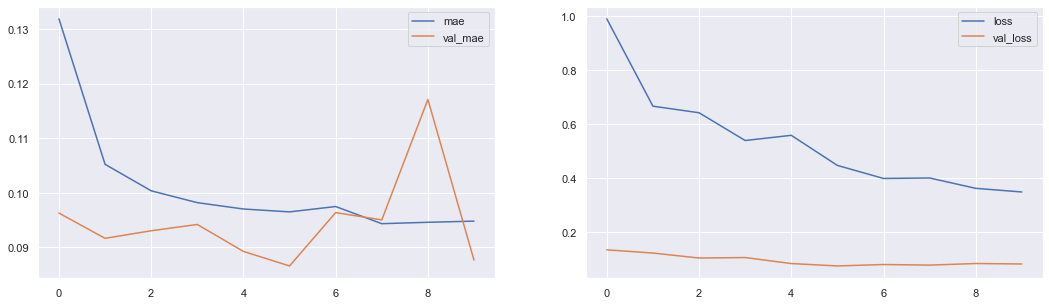

In [22]:
x = xTest
y = yTest
epochs = 10

model = Sequential()

model.add(Dense(64, input_shape=x[0].shape, activation="relu"))
model.add(Dense(32, activation="elu"))

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer=RMSprop(), metrics="mae")

history = model.fit(xTrain,
                   yTrain,
                   epochs=epochs,
                   batch_size=256,
                   validation_data=(xTest, yTest),
                   callbacks = [printMae],
                   verbose=False)



<AxesSubplot:>

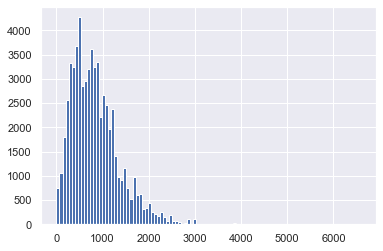

In [182]:
df["Примечание"].fillna("unknown").apply(len).hist(bins=100)

In [183]:
maxWords = 10000
texts = df["Примечание"].fillna("").values
tokenizer = Tokenizer(num_words=maxWords, oov_token="unknown")
tokenizer.fit_on_texts(texts)

xBow = tokenizer.texts_to_matrix(texts)




In [184]:
xBowTrain = xBow[:dsSlice]
xBowTest = xBow[dsSlice:]
del xBow
del df

In [195]:
gc.collect()

x = xBowTest
y = yTest

model = Sequential()

model.add(Dropout(0.1, input_shape=xBowTrain[0].shape))
model.add(Dense(128, input_shape=xBowTrain[0].shape, activation="elu"))
model.add(Dense(64, activation="relu"))

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer=RMSprop(), metrics="mae")

history = model.fit(xBowTrain,
                   yTrain,
                   epochs=10,
                   batch_size=512,
                   validation_data=(x, y),
                   callbacks=[printMae]
                   )


Epoch 1/10
96/98 [============================>.] - ETA: 0s - loss: 1.0970 - mae: 0.1249
Эпоха 0 средняя ошибка 1,920,294.0
98/98 [==============================] - 3s 30ms/step - loss: 1.0791 - mae: 0.1243 - val_loss: 0.2104 - val_mae: 0.0849
Epoch 2/10
96/98 [============================>.] - ETA: 0s - loss: 0.8854 - mae: 0.0827
Эпоха 1 средняя ошибка 1,811,883.0
98/98 [==============================] - 2s 25ms/step - loss: 0.8713 - mae: 0.0827 - val_loss: 0.2030 - val_mae: 0.0801
Epoch 3/10
97/98 [============================>.] - ETA: 0s - loss: 0.6567 - mae: 0.0716
Эпоха 2 средняя ошибка 1,980,374.0
98/98 [==============================] - 2s 25ms/step - loss: 0.6525 - mae: 0.0717 - val_loss: 0.2143 - val_mae: 0.0876
Epoch 4/10
92/98 [===========================>..] - ETA: 0s - loss: 0.4545 - mae: 0.0675
Эпоха 3 средняя ошибка 1,749,375.0
98/98 [==============================] - 2s 24ms/step - loss: 0.4313 - mae: 0.0675 - val_loss: 0.2089 - val_mae: 0.0774
Epoch 5/10
94/98 [======

In [196]:
gc.collect()

x = [xTest, xBowTest]
y = yTest


model = Model()

input1=Input(xTrain[0].shape)
input2=Input(xBowTrain[0].shape)

m1 = Dense(128, activation="elu")(input1)
m1 = Dense(64, activation="relu")(m1)

m2 = Dense(128, activation="elu")(input2)
m2 = Dense(64, activation="relu")(m2)

out = concatenate([m1, m2])
out = Dense(32, activation="relu")(out)
out = Dense(1, activation="linear")(out)

model = Model((input1, input2), out)

model.compile(optimizer=RMSprop(learning_rate=1/2**10), loss='mse', metrics=['mae'])

history = model.fit([xTrain, xBowTrain], 
                    yTrain, 
                    epochs=50,
                    batch_size=512, 
                    validation_data=(x, y), 
                    callbacks = [printMae],
                    verbose=1)

Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 0.6389 - mae: 0.0887
Эпоха 0 средняя ошибка 1,654,203.0
98/98 [==============================] - 4s 31ms/step - loss: 0.6389 - mae: 0.0887 - val_loss: 0.0831 - val_mae: 0.0732
Epoch 2/50
94/98 [===========================>..] - ETA: 0s - loss: 0.3809 - mae: 0.0594
Эпоха 1 средняя ошибка 1,504,170.0
98/98 [==============================] - 3s 27ms/step - loss: 0.3671 - mae: 0.0593 - val_loss: 0.0550 - val_mae: 0.0665
Epoch 3/50
93/98 [===========================>..] - ETA: 0s - loss: 0.1592 - mae: 0.0526
Эпоха 2 средняя ошибка 1,390,841.0
98/98 [==============================] - 3s 27ms/step - loss: 0.1521 - mae: 0.0529 - val_loss: 0.0504 - val_mae: 0.0615
Epoch 4/50
98/98 [==============================] - ETA: 0s - loss: 0.1196 - mae: 0.0458
Эпоха 3 средняя ошибка 1,546,150.0
98/98 [==============================] - 3s 27ms/step - loss: 0.1196 - mae: 0.0458 - val_loss: 0.0642 - val_mae: 0.0684
Epoch 5/50
93/98 [======

Epoch 35/50
96/98 [============================>.] - ETA: 0s - loss: 0.0422 - mae: 0.0203
Эпоха 34 средняя ошибка 1,003,378.0
98/98 [==============================] - 3s 26ms/step - loss: 0.0415 - mae: 0.0202 - val_loss: 0.1005 - val_mae: 0.0444
Epoch 36/50
96/98 [============================>.] - ETA: 0s - loss: 0.0351 - mae: 0.0203
Эпоха 35 средняя ошибка 1,057,159.0
98/98 [==============================] - 3s 27ms/step - loss: 0.0345 - mae: 0.0203 - val_loss: 0.0675 - val_mae: 0.0468
Epoch 37/50
98/98 [==============================] - ETA: 0s - loss: 0.0257 - mae: 0.0199
Эпоха 36 средняя ошибка 996,538.0
98/98 [==============================] - 3s 26ms/step - loss: 0.0257 - mae: 0.0199 - val_loss: 0.0824 - val_mae: 0.0441
Epoch 38/50
96/98 [============================>.] - ETA: 0s - loss: 0.0442 - mae: 0.0200
Эпоха 37 средняя ошибка 1,072,730.0
98/98 [==============================] - 3s 26ms/step - loss: 0.0435 - mae: 0.0200 - val_loss: 0.1035 - val_mae: 0.0474
Epoch 39/50
95/98 

In [208]:
gc.collect()
model.compile(optimizer=RMSprop(learning_rate=1/2**16), loss='mse', metrics=['mae'])

history = model.fit([xTrain, xBowTrain], 
                    yTrain, 
                    epochs=2,
                    batch_size=1024, 
                    validation_data=(x, y), 
                    callbacks = [printMae],
                    verbose=1)

Epoch 1/2
47/49 [===========================>..] - ETA: 0s - loss: 0.0045 - mae: 0.0076
Эпоха 0 средняя ошибка 939,854.0
49/49 [==============================] - 4s 65ms/step - loss: 0.0044 - mae: 0.0076 - val_loss: 0.0815 - val_mae: 0.0416
Epoch 2/2
48/49 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0076
Эпоха 1 средняя ошибка 939,986.0
49/49 [==============================] - 3s 53ms/step - loss: 0.0043 - mae: 0.0076 - val_loss: 0.0814 - val_mae: 0.0416


In [222]:
seq = tokenizer.texts_to_sequences(texts)
maxLen = 1500
seq = pad_sequences(seq, maxlen=maxLen, padding='post', truncating='post')

In [223]:
xSeqTrain = seq[:dsSlice]
xSeqTest = seq[dsSlice:]
del seq

In [224]:
gc.collect()

x = xSeqTest
y = yTest

model = Sequential()

model.add(Embedding(maxWords, 32, input_length=maxLen))
# model.add(SpatialDropout1D(0.75))
# model.add(Dropout(0.75))
# model.add(LSTM(32, return_sequences=True))
model.add(Conv1D(64, 64, strides=16, activation="relu"))

model.add(Flatten())
model.add(Dense(128, activation="elu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(optimizer=RMSprop(learning_rate=1/2**10), loss='mse', metrics=['mae'])

history = model.fit(
    xSeqTrain,
    yTrain,
    epochs=10,
    batch_size=512,
    validation_data=(xSeqTest, yTest),
    callbacks = [printMae]
    )


Epoch 1/10
98/98 [==============================] - ETA: 0s - loss: 1.2020 - mae: 0.1815
Эпоха 0 средняя ошибка 2,378,311.0
98/98 [==============================] - 11s 107ms/step - loss: 1.2020 - mae: 0.1815 - val_loss: 0.2399 - val_mae: 0.1052
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 1.0110 - mae: 0.1019
Эпоха 1 средняя ошибка 2,175,787.0
98/98 [==============================] - 11s 107ms/step - loss: 1.0110 - mae: 0.1019 - val_loss: 0.2212 - val_mae: 0.0962
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 0.7311 - mae: 0.0956
Эпоха 2 средняя ошибка 2,198,161.0
98/98 [==============================] - 11s 110ms/step - loss: 0.7311 - mae: 0.0956 - val_loss: 0.2145 - val_mae: 0.0972
Epoch 4/10
47/98 [=============>................] - ETA: 4s - loss: 0.4557 - mae: 0.0997

KeyboardInterrupt: 

In [225]:
gc.collect()

x = [xTest, xBowTest, xSeqTest]
y = yTest

model = Model()

input1=Input(xTrain[0].shape)
input2=Input(xBowTrain[0].shape)
input3=Input(xSeqTrain[0].shape)

m1 = Dense(128, activation="elu")(input1)
m1 = Dense(64, activation="relu")(m1)

m2 = Dense(128, activation="elu")(input2)
m2 = Dense(64, activation="relu")(m2)

m3 = Embedding(maxWords, 32)(input3)
m3 = Conv1D(64, 64, strides=16, activation="relu")(m3)
m3 = Flatten()(m3)
m3 = Dense(128, activation="elu")(m3)
m3 = Dense(64, activation="relu")(m3)


out = concatenate([m1, m2, m3])
out = Dense(32, activation="relu")(out)
out = Dense(1, activation="linear")(out)

model = Model((input1, input2, input3), out)

model.compile(optimizer=RMSprop(learning_rate=1/2**10), loss='mse', metrics=['mae'])

history = model.fit([xTrain, xBowTrain, xSeqTrain], 
                    yTrain, 
                    epochs=50,
                    batch_size=512, 
                    validation_data=(x, y), 
                    callbacks = [printMae],
                    verbose=1)

Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 0.8040 - mae: 0.1097
Эпоха 0 средняя ошибка 2,983,190.0
98/98 [==============================] - 14s 127ms/step - loss: 0.8040 - mae: 0.1097 - val_loss: 0.1042 - val_mae: 0.1319
Epoch 2/50
98/98 [==============================] - ETA: 0s - loss: 0.3994 - mae: 0.0686
Эпоха 1 средняя ошибка 1,298,145.0
98/98 [==============================] - 12s 121ms/step - loss: 0.3994 - mae: 0.0686 - val_loss: 0.0574 - val_mae: 0.0574
Epoch 3/50
98/98 [==============================] - ETA: 0s - loss: 0.1536 - mae: 0.0568
Эпоха 2 средняя ошибка 1,250,498.0
98/98 [==============================] - 12s 121ms/step - loss: 0.1536 - mae: 0.0568 - val_loss: 0.0547 - val_mae: 0.0553
Epoch 4/50
98/98 [==============================] - ETA: 0s - loss: 0.0817 - mae: 0.0503
Эпоха 3 средняя ошибка 1,215,987.0
98/98 [==============================] - 12s 125ms/step - loss: 0.0817 - mae: 0.0503 - val_loss: 0.0773 - val_mae: 0.0538
Epoch 5/50
98/98

In [226]:
gc.collect()
model.compile(optimizer=RMSprop(learning_rate=1/2**10), loss='mse', metrics=['mae'])

history = model.fit([xTrain, xBowTrain, xSeqTrain], 
                    yTrain, 
                    epochs=10,
                    batch_size=256, 
                    validation_data=(x, y), 
                    callbacks = [printMae],
                    verbose=1)

Epoch 1/10
196/196 [==============================] - ETA: 0s - loss: 0.0093 - mae: 0.0187
Эпоха 0 средняя ошибка 1,014,876.0
196/196 [==============================] - 17s 77ms/step - loss: 0.0093 - mae: 0.0187 - val_loss: 0.0454 - val_mae: 0.0449
Epoch 2/10
195/196 [============================>.] - ETA: 0s - loss: 0.0413 - mae: 0.0188
Эпоха 1 средняя ошибка 1,025,233.0
196/196 [==============================] - 12s 62ms/step - loss: 0.0412 - mae: 0.0188 - val_loss: 0.0510 - val_mae: 0.0453
Epoch 3/10
195/196 [============================>.] - ETA: 0s - loss: 0.0451 - mae: 0.0194
Эпоха 2 средняя ошибка 1,004,002.0
196/196 [==============================] - 12s 63ms/step - loss: 0.0451 - mae: 0.0193 - val_loss: 0.0541 - val_mae: 0.0444
Epoch 4/10
195/196 [============================>.] - ETA: 0s - loss: 0.0041 - mae: 0.0176
Эпоха 3 средняя ошибка 1,064,031.0
196/196 [==============================] - 12s 63ms/step - loss: 0.0041 - mae: 0.0175 - val_loss: 0.0847 - val_mae: 0.0471
Epoc

In [227]:
gc.collect()
model.compile(optimizer=RMSprop(learning_rate=1/2**12), loss='mse', metrics=['mae'])

history = model.fit([xTrain, xBowTrain, xSeqTrain], 
                    yTrain, 
                    epochs=10,
                    batch_size=256, 
                    validation_data=(x, y), 
                    callbacks = [printMae],
                    verbose=1)

Epoch 1/10
195/196 [============================>.] - ETA: 0s - loss: 0.0128 - mae: 0.0134
Эпоха 0 средняя ошибка 933,544.0
196/196 [==============================] - 14s 65ms/step - loss: 0.0128 - mae: 0.0134 - val_loss: 0.0562 - val_mae: 0.0413
Epoch 2/10
196/196 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0107
Эпоха 1 средняя ошибка 928,315.0
196/196 [==============================] - 12s 64ms/step - loss: 0.0015 - mae: 0.0107 - val_loss: 0.0562 - val_mae: 0.0411
Epoch 3/10
195/196 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0101
Эпоха 2 средняя ошибка 924,564.0
196/196 [==============================] - 12s 63ms/step - loss: 0.0042 - mae: 0.0101 - val_loss: 0.0556 - val_mae: 0.0409
Epoch 4/10
195/196 [============================>.] - ETA: 0s - loss: 0.0020 - mae: 0.0095
Эпоха 3 средняя ошибка 924,463.0
196/196 [==============================] - 13s 64ms/step - loss: 0.0020 - mae: 0.0095 - val_loss: 0.0535 - val_mae: 0.0409
Epoch 5/10
1

In [228]:
gc.collect()
model.compile(optimizer=RMSprop(learning_rate=1/2**14), loss='mse', metrics=['mae'])

history = model.fit([xTrain, xBowTrain, xSeqTrain], 
                    yTrain, 
                    epochs=10,
                    batch_size=128, 
                    validation_data=(x, y), 
                    callbacks = [printMae],
                    verbose=1)

Epoch 1/10
390/391 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0075
Эпоха 0 средняя ошибка 914,670.0
391/391 [==============================] - 16s 37ms/step - loss: 0.0011 - mae: 0.0075 - val_loss: 0.0523 - val_mae: 0.0404
Epoch 2/10
389/391 [============================>.] - ETA: 0s - loss: 7.8989e-04 - mae: 0.0071
Эпоха 1 средняя ошибка 913,026.0
391/391 [==============================] - 14s 35ms/step - loss: 7.8720e-04 - mae: 0.0071 - val_loss: 0.0537 - val_mae: 0.0404
Epoch 3/10
390/391 [============================>.] - ETA: 0s - loss: 6.7294e-04 - mae: 0.0070
Эпоха 2 средняя ошибка 914,157.0
391/391 [==============================] - 14s 36ms/step - loss: 6.7218e-04 - mae: 0.0070 - val_loss: 0.0550 - val_mae: 0.0404
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss: 7.5318e-04 - mae: 0.0069
Эпоха 3 средняя ошибка 912,741.0
391/391 [==============================] - 14s 35ms/step - loss: 7.5318e-04 - mae: 0.0069 - val_loss: 0.0526 - val_

In [229]:
gc.collect()
model.compile(optimizer=RMSprop(learning_rate=1/2**16), loss='mse', metrics=['mae'])

history = model.fit([xTrain, xBowTrain, xSeqTrain], 
                    yTrain, 
                    epochs=10,
                    batch_size=64, 
                    validation_data=(x, y), 
                    callbacks = [printMae],
                    verbose=1)

Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 5.4155e-04 - mae: 0.0062
Эпоха 0 средняя ошибка 912,629.0
782/782 [==============================] - 18s 21ms/step - loss: 5.4155e-04 - mae: 0.0062 - val_loss: 0.0530 - val_mae: 0.0404
Epoch 2/10
782/782 [==============================] - ETA: 0s - loss: 5.0900e-04 - mae: 0.0062
Эпоха 1 средняя ошибка 912,677.0
782/782 [==============================] - 15s 20ms/step - loss: 5.0900e-04 - mae: 0.0062 - val_loss: 0.0539 - val_mae: 0.0404
Epoch 3/10
781/782 [============================>.] - ETA: 0s - loss: 5.0300e-04 - mae: 0.0061
Эпоха 2 средняя ошибка 912,780.0
782/782 [==============================] - 16s 20ms/step - loss: 5.0286e-04 - mae: 0.0061 - val_loss: 0.0543 - val_mae: 0.0404
Epoch 4/10
780/782 [============================>.] - ETA: 0s - loss: 4.6534e-04 - mae: 0.0060
Эпоха 3 средняя ошибка 913,261.0
782/782 [==============================] - 15s 20ms/step - loss: 4.6467e-04 - mae: 0.0060 - val_loss: 0.054

In [ ]:
# Эпоха 9 средняя ошибка 913,754.0